In [1]:
import os

# Set datapath properly
path = os.getcwd() + "/data/"

if not os.path.exists(path):
  os.makedirs(path)

%env DATAPATH={path}

raw = 's.rsf'
raw_hfile = 's_hfile.rsf'
raw_tfile = 's_tfile.txt'
raw_bfile = 's_bfile.txt'
raw_deghost = "s_deghost.rsf"
raw_deghost_cdp = 's_deghost_cdp.rsf'
raw_deghost_gain = "s_deghost_gain.rsf"
raw_deghost_gain_cdp = "s_deghost_gain_cdp.rsf"
raw_deghost_gain_mute = "s_deghost_gain_mute.rsf"
raw_deghost_gain_mute_cdp = "s_deghost_gain_mute_dip_cdp.rsf"
raw_deghost_gain_mute_dip = "s_deghost_gain_mute_dip.rsf"
raw_deghost_gain_mute_dip_cdp = "s_deghost_gain_mute_dip_cdp.rsf"
vnmo_rsf = 'vnmo.rsf'
vnmow_rsf = 'vnmow.rsf'
vnmo_auto_rsf = "vnmo_auto.rsf"
vnmo_auto_smooth_rsf = "vnmo_auto_smooth.rsf"
sample = 'sample.rsf'
sample_deghost = 'sample_deghost.rsf'
sample_deghost_gain = 'sample_deghost_gain.rsf'
sample_deghost_gain_mute = 'sample_deghost_gain_mute.rsf'
sample_deghost_gain_mute_cdp = 'sample_deghost_gain_mute_cdp.rsf'
sample_deghost_gain_mute_dip = 'sample_deghost_gain_mute_dip.rsf'
sample_deghost_gain_mute_dip_cdp = 'sample_deghost_gain_mute_dip_cdp.rsf'
header_complete = 'sp_header_complete.rsf'
header_complete_int = 'sp_header_complete_int.rsf'
cdp_offsets = 'cdp_offsets.rsf'
sample_offsets = 'sample_cdp_offsets.rsf'
cdp_mask = "cdp_mask.rsf"
wavelet_file = os.getcwd() + "/../FarField.dat"

import numpy as np
import pandas as pd
from rsf.proj import *
import rsf.api as sf
import m8r
from m8r import view
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import periodogram, welch
from wiggle.wiggle import wiggle
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

env: DATAPATH=/home/kerim/Documents/JUDI.jl/examples/field_examples/viking_graben_line12/proc/data/


Extract CDP sample

In [2]:
sample_deghost_gain_mute_dip_cdp = 'sample_deghost_gain_mute_dip_cdp.rsf'

cdp = 1530
# cdp = 1000
!sfwindow f3={cdp} n3=1 < {raw_deghost_gain_mute_dip_cdp} > {sample_deghost_gain_mute_dip_cdp}
!sfintbin < {header_complete} head={header_complete_int} yk=cdp xk=cdpt | \
    sfwindow f3={cdp} n3=1 | \
    sfheadermath output='offset'/1000. > {sample_offsets}

sfintbin: 2142 of 2142;


Check NMO

sfnmo: CMP 1 of 1;


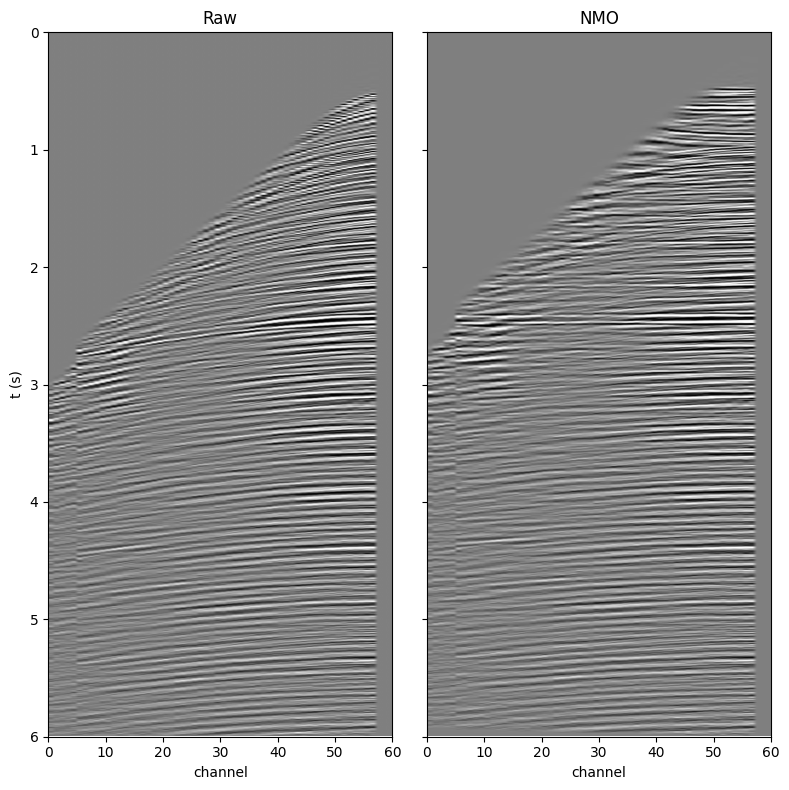

In [3]:
sample_nmo = "sample_receiver_deghost_gain_mute_dip_nmo_cdp.rsf"

raw=sample_deghost_gain_mute_dip_cdp
proc=sample_nmo

!sfnmo < {raw} velocity={vnmo_rsf} half=n offset={sample_offsets} > {proc}
# !sfnmo < s_deghost_gain_dip_mute_cdp.rsf velocity={vnmo_rsf} half=n offset={cdp_offsets} | sfwindow f3=1000 n3=1 > {raw}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw", "NMO"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr]):
    plt.subplot(1,2, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Check Forward Radon

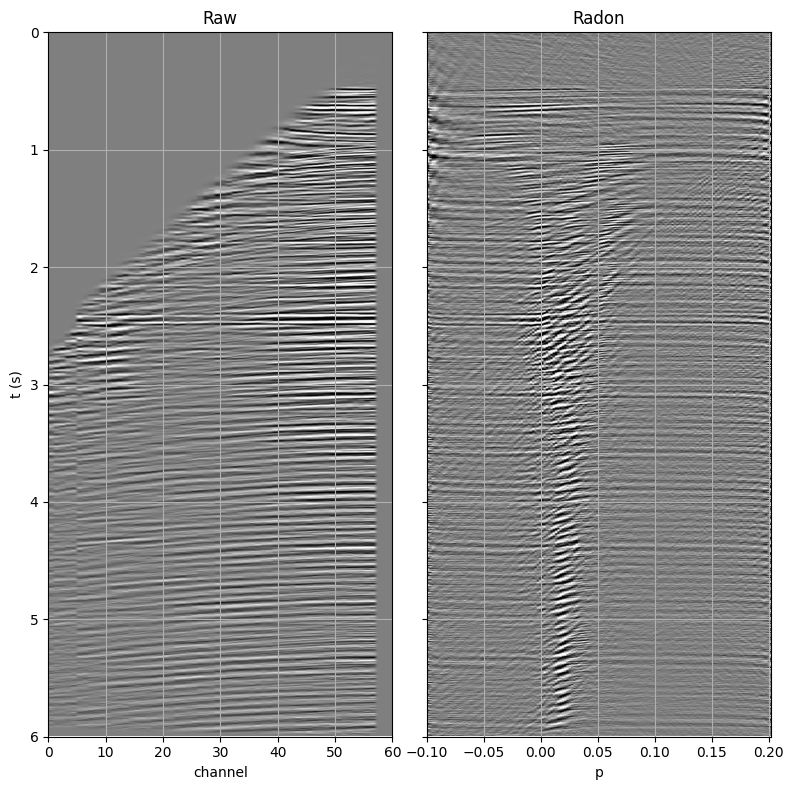

In [4]:
sample_radon = "sample_deghost_gain_mute_dip_nmo_radon_cdp.rsf"

raw=sample_nmo
proc=sample_radon
# _p0=-0.1
# _np=500
# _dp=2*abs(_p0)/(_np-1)
_p0=-0.1
_np=151
# _dp=2*abs(_p0)/(_np-1)
_dp=0.002
spk='y' # if 'yes' then do spiking (high-resolution) transform

# radon adj=y spk=n parab=y p0=-0.1 dp=0.002 np=151'
!sfradon < {raw} adj=y parab=y spk={spk} p0={_p0} dp={_dp} np={_np} offset={sample_offsets} > {proc}
# !sfwindow < tmp.rsf f3=1000 n3=1 > {raw}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw", "Radon"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr]):
    plt.subplot(1,2, i+1)
    perc = np.percentile(data.ravel(), 99)
    if i == 1:
        extent = [_p0, _p0+_dp*_np, t[-1], t[0]]
    else:
        extent = [0, data.shape[0], t[-1], t[0]]
    # extent = [_p0, _p0+_dp*_np, t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
        plt.xlabel('channel')
    else:
        plt.xlabel('p')
    plt.title(titles[i])
    plt.ylim(6,0)
    plt.grid()

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Check Inverse Radon

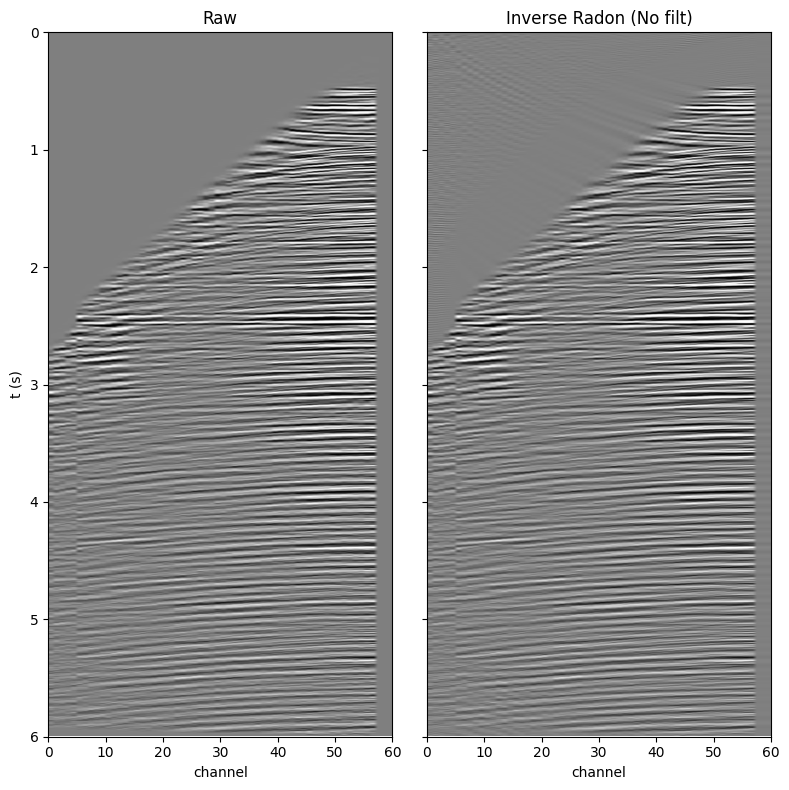

In [5]:
sample_radon_inv = "sample_receiver_deghost_gain_mute_dip_nmo_radon_inv_cdp.rsf"

raw=sample_nmo
proc=sample_radon_inv

ox=0.287
nx=60
dx=0.05
!sfradon < {sample_radon} adj=n ox={ox} nx={nx} dx={dx} parab=y spk={spk} offset={sample_offsets} |\
    sfput 02=0 d2=1 > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw", "Inverse Radon (No filt)"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr]):
    plt.subplot(1,2, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Filter with Radon transofrm

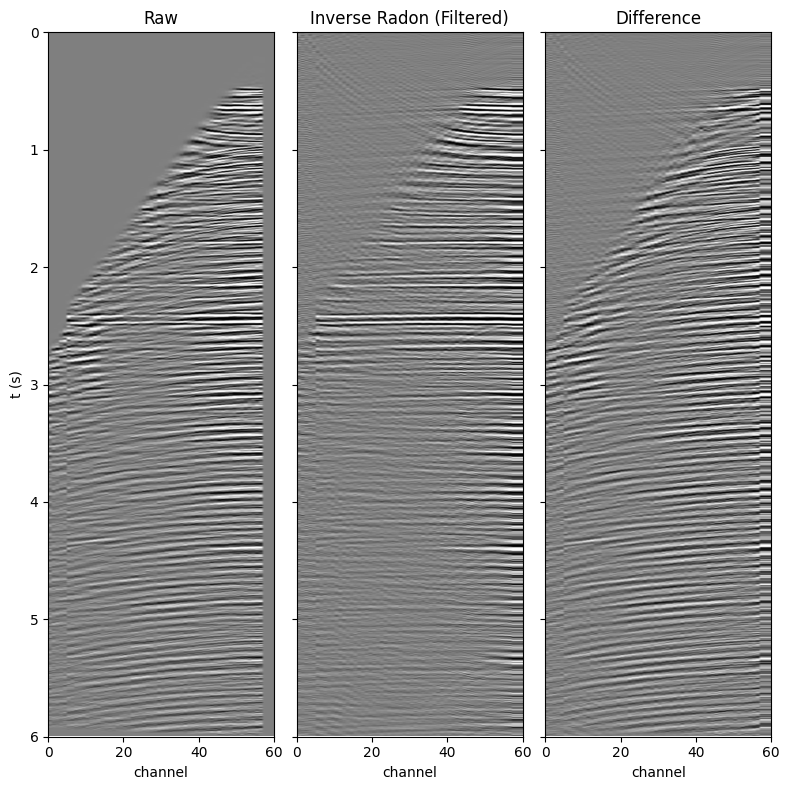

In [6]:
sample_radon_inv_filt = "sample_deghost_gain_mute_dip_nmo_radon_inv_filt_cdp.rsf"

raw=sample_nmo
proc=sample_radon_inv_filt

# min/max time for noise
# min1=0.75
min1=0
max1=6
# min/max curvature for noise
min2=0.01
max2=_p0+_dp*(_np-5)

!sfcut < {sample_radon} min1={min1} max1={max1} min2={min2} max2={max2} | \
    sfradon adj=n ox={ox} nx={nx} dx={dx} parab=y spk={spk} offset={sample_offsets} |\
    sfput 02=0 d2=1 > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw", "Inverse Radon (Filtered)", "Difference"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Dip filt (CDP)

sffft1: using 8 of 8 threads
sffft1: using 8 of 8 threads
sffft3: padded to 120


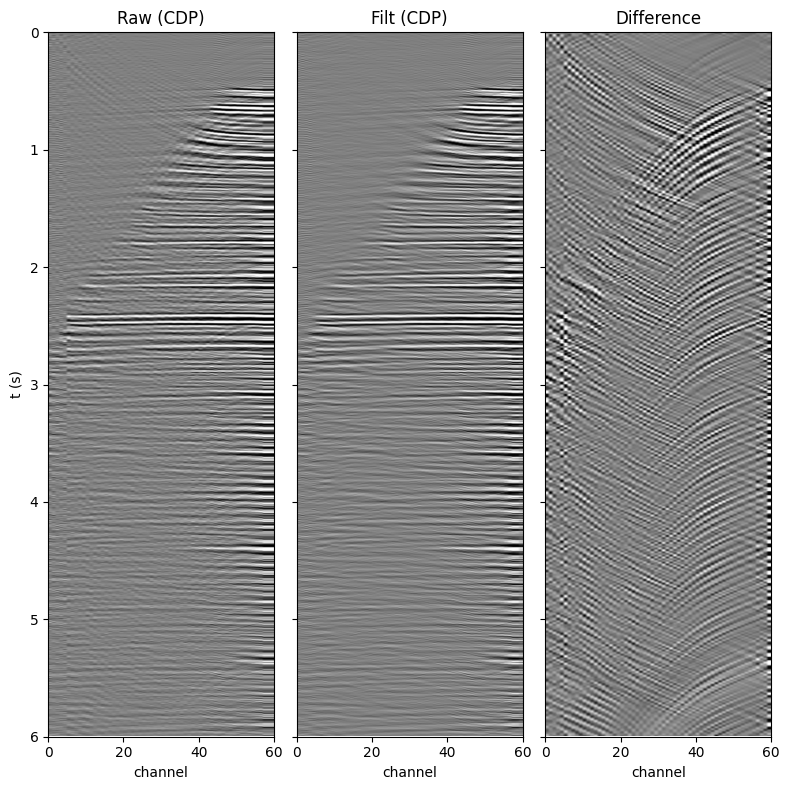

In [7]:
sample_radon_inv_filt_dip = 'sample_deghost_gain_mute_dip_nmo_radon_inv_filt_dip_cdp.rsf'
raw = sample_radon_inv_filt
proc = sample_radon_inv_filt_dip

# process
v1 = -93
v2 = -80
v3 =  80
v4 =  93
!sffft1 < {raw} | sffft3 | \
    sfdipfilter v1={v1} v2={v2} v3={v3} v4={v4} pass=n | \
    sffft3 inv=y | sffft1 inv=y > {proc}
# !sfwindow < {raw} 01=0 > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw (CDP)", "Filt (CDP)", "Difference"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    # rms = np.sqrt(np.mean(data**2, axis=0))
    # coef = data.shape[0]/(rms.max()-rms.min())
    # rms_normilized = (rms-rms.min())*coef
    # plt.plot(rms_normilized, t)
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Visualize FK spectrums (CDP)

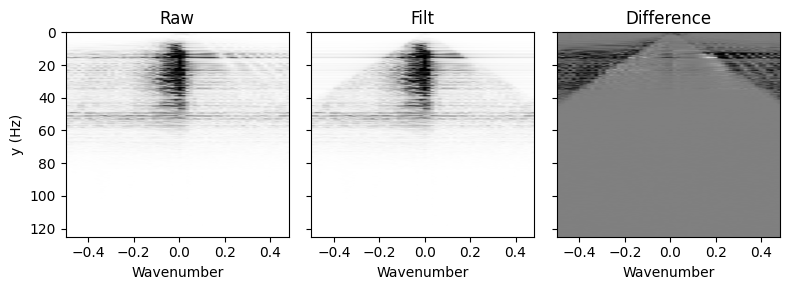

In [8]:
raw = "fft_raw.rsf"
proc = "fft_proc.rsf"

# process
!sfspectra2 < {sample_radon_inv_filt} > {raw}
!sfspectra2 < {sample_radon_inv_filt_dip} > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw)
o1 = raw_in.float('o1')
o2 = raw_in.float('o2')
d1 = raw_in.float('d1')
d2 = raw_in.float('d2')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

x = o2 + np.arange(raw_arr.shape[0]) * d2
y = o1 + np.arange(raw_arr.shape[1]) * d1

titles = ["Raw", "Filt", "Difference"]
plt.figure(figsize=(8,3))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [x[0], x[-1], y[-1], y[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('y (Hz)')
    plt.xlabel('Wavenumber')
    plt.title(titles[i])
    # plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Compare INMO

sfinmo: CMP 1 of 1;
sfinmo: CMP 1 of 1;


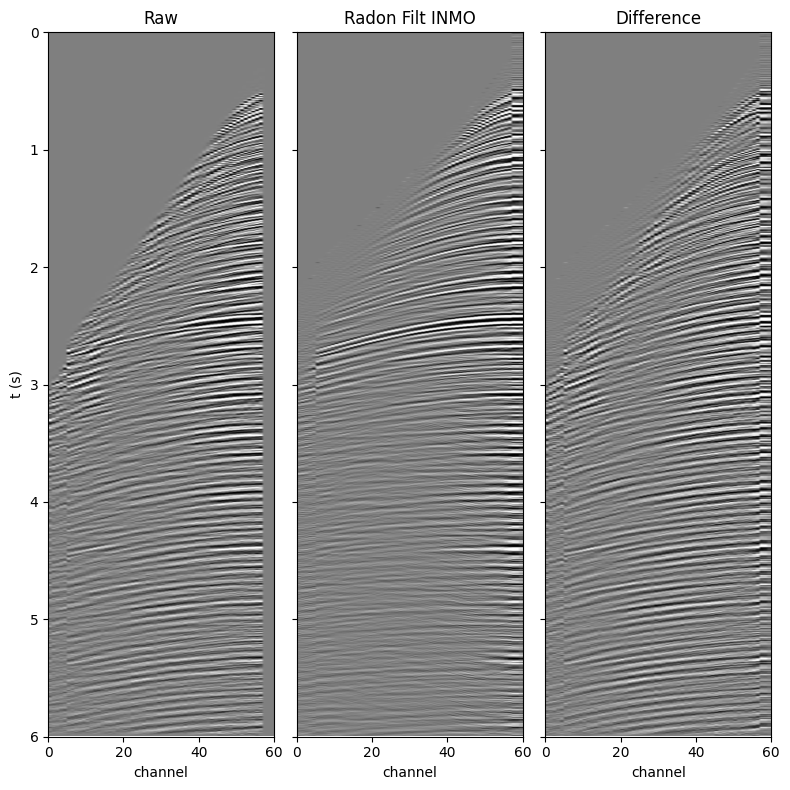

In [9]:
sample_nmo_inmo = "sample_receiver_deghost_gain_mute_dip_nmo_inmo_cdp.rsf"
sample_radon_inv_filt_dip_inmo = "sample_receiver_deghost_gain_mute_dip_nmo_radon_inv_filt_dip_inmo_cdp.rsf"

raw=sample_nmo
raw_proc=sample_nmo_inmo
proc=sample_radon_inv_filt_dip_inmo

!sfinmo < {raw} velocity={vnmo_rsf} half=n offset={sample_offsets} > {raw_proc}
!sfinmo < {sample_radon_inv_filt_dip} velocity={vnmo_rsf} half=n offset={sample_offsets} > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw_proc)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw", "Radon Filt INMO", "Difference"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Compare VELSCANS

sfvscan: cmp 1 of 1;
sfvscan: cmp 1 of 1;
sfpick: cmp 1 of 1;
sfpick: iteration 0 res: 1.000000 grad: 0.000000
sfpick: iteration 1 res: 0.522796 grad: 0.125415
sfpick: iteration 2 res: 0.374793 grad: 0.040924
sfpick: iteration 3 res: 0.258677 grad: 0.043891
sfpick: iteration 4 res: 0.124759 grad: 0.015601
sfpick: iteration 5 res: 0.067029 grad: 0.011001
sfpick: iteration 6 res: 0.041281 grad: 0.011494
sfpick: iteration 7 res: 0.034713 grad: 0.011353
sfpick: iteration 8 res: 0.015370 grad: 0.002553
sfpick: iteration 9 res: 0.011136 grad: 0.004539
sfpick: iteration 10 res: 0.006956 grad: 0.001346
sfpick: iteration 11 res: 0.004732 grad: 0.000932
sfpick: iteration 12 res: 0.003508 grad: 0.001244
sfpick: iteration 13 res: 0.003067 grad: 0.000698
sfpick: iteration 14 res: 0.001913 grad: 0.000243
sfpick: iteration 15 res: 0.001185 grad: 0.000131
sfpick: iteration 16 res: 0.000847 grad: 0.000209
sfpick: iteration 17 res: 0.000665 grad: 0.000114
sfpick: iteration 18 res: 0.000576 grad: 0.00026

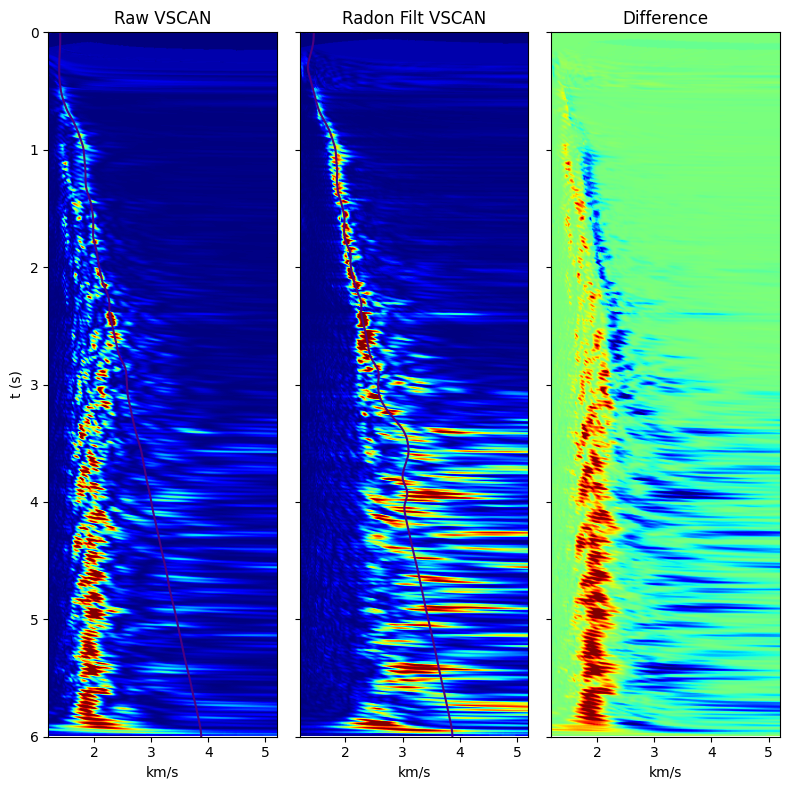

In [10]:
sample_vscan = "sample_deghost_gain_mute_dip_vscan.rsf"
sample_radon_inv_filt_dip_inmo_vscan = "sample_deghost_gain_mute_dip_nmo_radon_inv_filt_inmo_vscan.rsf"

raw=sample_vscan
proc=sample_radon_inv_filt_dip_inmo_vscan
raw_picks="picks_fk.rsf"
proc_picks="picks_fk_radon.rsf"

v0=1.2
dv=0.02
nv=201
nb=2
!sfvscan < {sample_nmo_inmo} offset={sample_offsets} v0={v0} dv={dv} nv={nv} nb={nb} semblance=y half=n > {raw}
!sfvscan < {sample_radon_inv_filt_dip_inmo} offset={sample_offsets} v0={v0} dv={dv} nv={nv} nb={nb} semblance=y half=n > {proc}
# !sfvscan < {sample_deghost_gain_mute_dip_cdp} offset={sample_offsets} v0={v0} dv={dv} nv={nv} nb={nb} semblance=y half=n |\
#     sfmutter inner=y x0=1.4 half=n v0=0.45 t0=0.5 > {raw}
# !sfvscan < {sample_radon_inv_filt_dip_inmo} offset={sample_offsets} v0={v0} dv={dv} nv={nv} nb={nb} semblance=y half=n |\
#     sfmutter inner=y x0=1.4 half=n v0=0.45 t0=0.5 > {proc}

rect1=15
rect2=5
vel0=1.5
!sfmutter < {raw} inner=y x0=1.4 half=n v0=0.45 t0=0.5 | sfpick rect1={rect1} rect2={rect2} vel0={vel0} back=y > {raw_picks}
!sfmutter < {proc} inner=y x0=1.4 half=n v0=0.45 t0=0.5 | sfpick rect1={rect1} rect2={rect2} vel0={vel0} back=y > {proc_picks}
# !sfpick < {raw} rect1={rect1} rect2={rect2} vel0={vel0} back=y > {raw_picks}
# !sfpick < {proc} rect1={rect1} rect2={rect2} vel0={vel0} back=y > {proc_picks}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))
raw_picks_arr = np.array(sf.Input(raw_picks))
proc_picks_arr = np.array(sf.Input(proc_picks))
picks_list = [raw_picks_arr, proc_picks_arr]

titles = ["Raw VSCAN", "Radon Filt VSCAN", "Difference"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [v0, v0+dv*(nv-1), t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='jet')
    if i == 0:
        plt.ylabel('t (s)')
    if i < 2:
        plt.plot(picks_list[i],t, color="Indigo")
    plt.xlabel('km/s')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Now apply the processing to the whole dataset

In [11]:
raw_deghost_gain_mute_dip_radon_cdp = "s_deghost_gain_mute_dip_radon_cdp.rsf"
header_complete_int_cdp = "sp_header_complete_int_cdp.rsf"

raw = raw_deghost_gain_mute_dip_cdp
proc = raw_deghost_gain_mute_dip_radon_cdp

# mutter
_t0=0
_v0=1.1

# run
!sfnmo < {raw} velocity={vnmo_rsf} half=n offset={cdp_offsets} | \
    sfradon adj=y parab=y spk={spk} p0={_p0} dp={_dp} np={_np} offset={cdp_offsets} | \
    sfcut min1={min1} max1={max1} min2={min2} max2={max2} | \
    sfradon adj=n ox={ox} nx={nx} dx={dx} parab=y spk={spk} offset={cdp_offsets} | \
    sfput o2=0 d2=1 | \
    sffft1 | sffft3 |\
    sfdipfilter v1={v1} v2={v2} v3={v3} v4={v4} pass=n | \
    sffft3 inv=y | sffft1 inv=y |\
    sfinmo velocity={vnmo_rsf} half=n offset={cdp_offsets} | \
    sfheadercut mask={cdp_mask} | \
    sfmutter offset={cdp_offsets} half=n t0={_t0} v0={_v0} > {proc}
!sfintbin < {header_complete_int} yk=cdp xk=cdpt head={header_complete_int} > {header_complete_int_cdp}

sfnmo: CMP 2 of 2142;sffft1: using 8 of 8 threads
sfnmo: CMP 3 of 2142;sffft1: using 8 of 8 threads
sfnmo: CMP 2142 of 2142;
sffft3: padded to 120
sfinmo: CMP 2142 of 2142;
sfintbin: 2142 of 2142;


Compare stacks

sfnmo: CMP 2142 of 2142;
sfnmo: CMP 2142 of 2142;


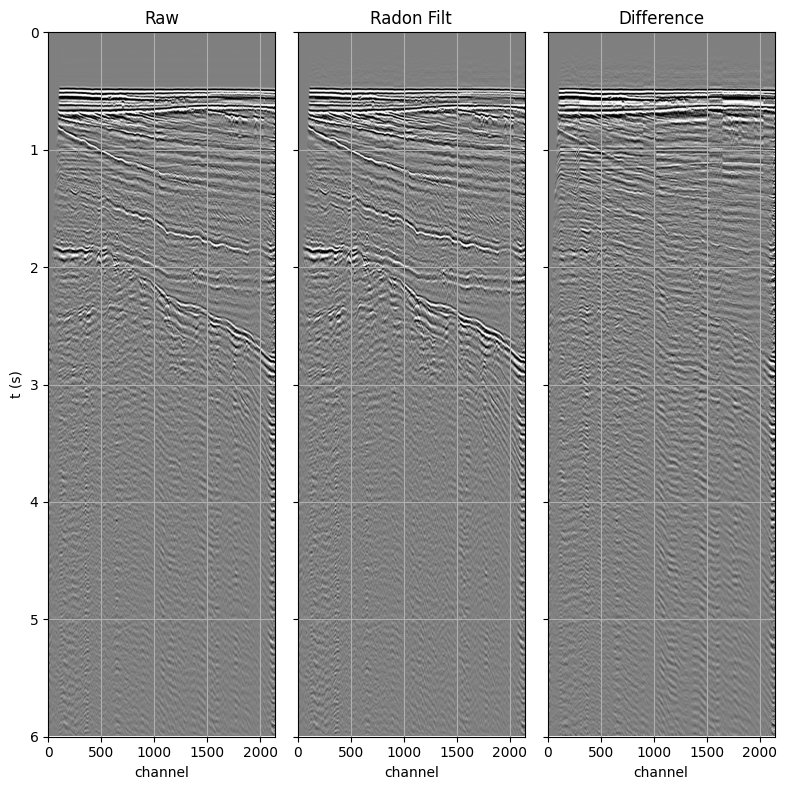

In [12]:
raw = raw_deghost_gain_mute_dip_cdp
proc = raw_deghost_gain_mute_dip_radon_cdp

raw_stack = 's_deghost_gain_mute_dip_cdp_stk.rsf'
proc_stack = 's_deghost_gain_mute_dip_radon_cdp_stk.rsf'

!sfnmo < {raw} velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
    sfstack > {raw_stack}

!sfnmo < {proc} velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
    sfstack > {proc_stack}

# Load stacks and visualize it
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

titles = ["Raw", "Radon Filt", "Difference"]
plt.figure(figsize=(8, 8))
for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)
    plt.grid()

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)